<a href="https://colab.research.google.com/github/shivaanisekharan/Emotion-detection-Project/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark


In [ ]:
# Import the necessary library
import pandas as pd

# Load the CSV files
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Display the first 5 rows of each dataset
print("Movies Data:")
print(movies.head())

print("\nRatings Data:")
print(ratings.head())

# Check for missing values in both datasets
print("\nMissing Values in Movies Dataset:")
print(movies.isnull().sum())

print("\nMissing Values in Ratings Dataset:")
print(ratings.isnull().sum())

# This output displays the first few records from both the Movies and Ratings datasets to verify data structure.
# Additionally, we've checked for missing values in both datasets, confirming data completeness (no missing values).
# This ensures we can proceed confidently without data imputation or cleaning at this stage.


Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Missing Values in Movies Dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings Dataset:
userId       0
movieId    

In [ ]:
# Step 5: Data Cleaning

# 1. Remove the 'timestamp' column from the ratings dataset
ratings = ratings.drop('timestamp', axis=1)

# 2. Check the data types to ensure they're correct
print("Data Types in Movies Dataset:")
print(movies.dtypes)

print("\nData Types in Ratings Dataset:")
print(ratings.dtypes)

# 3. Check for duplicate records in both datasets
print("\nDuplicate Records in Movies Dataset:", movies.duplicated().sum())
print("Duplicate Records in Ratings Dataset:", ratings.duplicated().sum())

# 4. Remove any duplicate records if found
movies = movies.drop_duplicates()
ratings = ratings.drop_duplicates()

# 5. Confirm changes
print("\nData after Cleaning:")
print("Movies Dataset Shape:", movies.shape)
print("Ratings Dataset Shape:", ratings.shape)

# Verified data types for both Movies and Ratings datasets to ensure compatibility for analysis.
# Checked for duplicate records and confirmed none exist, maintaining data integrity.
# Data cleaning is complete, with the Movies dataset having 9,742 records and the Ratings dataset having 100,836 records.
# Ready for further preprocessing or analysis.


Data Types in Movies Dataset:
movieId     int64
title      object
genres     object
dtype: object

Data Types in Ratings Dataset:
userId       int64
movieId      int64
rating     float64
dtype: object

Duplicate Records in Movies Dataset: 0
Duplicate Records in Ratings Dataset: 0

Data after Cleaning:
Movies Dataset Shape: (9742, 3)
Ratings Dataset Shape: (100836, 3)


In [ ]:
# Step 6: Data Preprocessing for Recommendations

# 1. Create the User-Item Matrix (Pivot Table)
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# 2. Fill missing values with 0 (indicating unrated movies)
user_item_matrix = user_item_matrix.fillna(0)

# 3. Display the User-Item Matrix
print("User-Item Matrix:")
print(user_item_matrix.head())

# 4. Check the shape of the matrix
print("\nShape of User-Item Matrix:", user_item_matrix.shape)

# Created the User-Item Matrix with 610 users and 9,724 movies.
# Non-zero values indicate user ratings, while zeros represent unrated movies.
# The matrix is sparse, which is common in recommendation systems due to limited user ratings per movie.
# This matrix will be used to calculate user-user similarities and generate personalized recommendations.



User-Item Matrix:
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0    

In [ ]:
# Step 7: Building the Recommendation Model

# 1. Import necessary libraries
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 2. Calculate the Cosine Similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# 3. Convert the similarity matrix to a DataFrame for better readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# 4. Display the User Similarity Matrix
print("User Similarity Matrix:")
print(user_similarity_df.head())

# 5. Function to get movie recommendations for a specific user
def recommend_movies(user_id, num_recommendations=5):
    # Get the similarity scores for the given user
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)

    # Exclude the user itself
    similar_users = similar_users.drop(user_id)

    # Find the most similar user
    most_similar_user = similar_users.index[0]

    # Get movies rated by the most similar user
    movies_rated_by_similar_user = user_item_matrix.loc[most_similar_user]

    # Recommend movies that the target user hasn't rated yet
    recommendations = movies_rated_by_similar_user[movies_rated_by_similar_user > 0]
    recommendations = recommendations[user_item_matrix.loc[user_id] == 0]

    # Sort by rating and return top N recommendations
    return recommendations.sort_values(ascending=False).head(num_recommendations)

# 6. Test the Recommendation System
recommended_movies = recommend_movies(user_id=1, num_recommendations=5)

# 7. Display the recommended movie IDs
print("\nRecommended Movie IDs for User 1:")
print(recommended_movies.index.tolist())

# 8. Display the recommended movie titles
print("\nRecommended Movie Titles for User 1:")
print(movies[movies['movieId'].isin(recommended_movies.index)][['movieId', 'title']])


User Similarity Matrix:
userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   

userId       8         9         10   ...       601       602       603  \
userId                                ...                                 
1       0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
2       0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
3       0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
4       0.062969  0.011361  0.031163  ..

<ipython-input-7-47d822c2c8e7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_avg', y='title', data=top_movies, palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


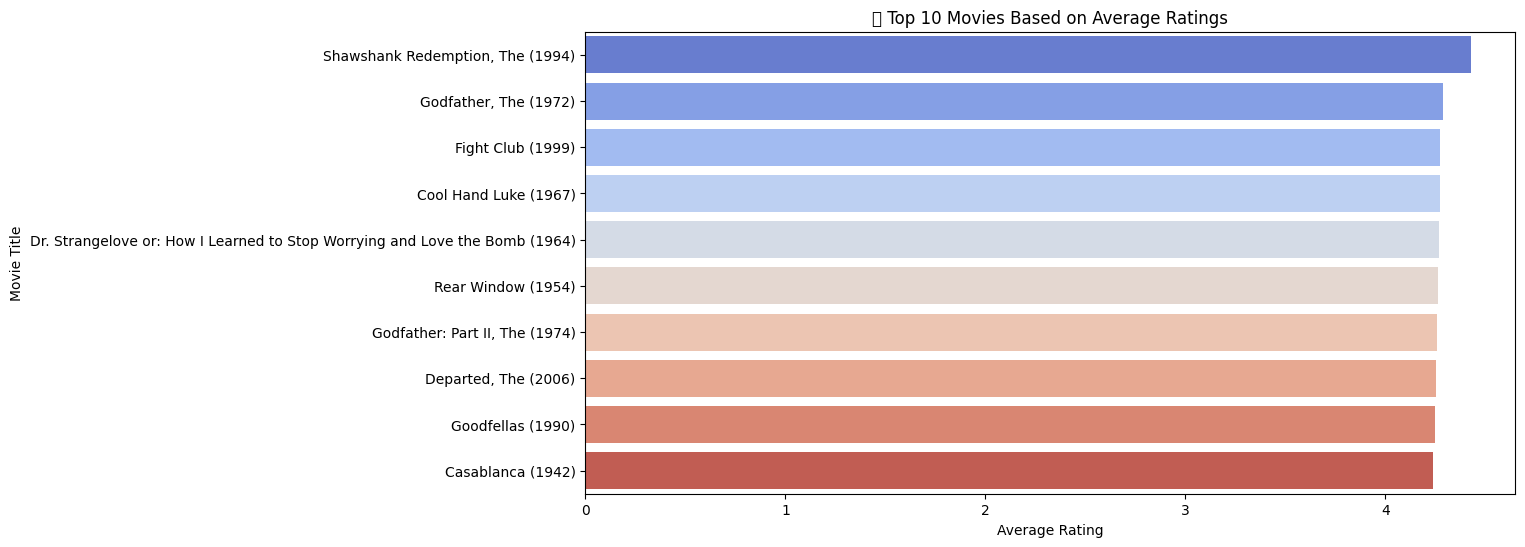

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average ratings for each movie
average_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
rating_counts = ratings.groupby('movieId')['rating'].count()

# Merge with movie titles
popular_movies = movies.merge(average_ratings, on='movieId')
popular_movies = popular_movies.merge(rating_counts, on='movieId', suffixes=('_avg', '_count'))

# Filter movies with at least 50 ratings for reliability
popular_movies_filtered = popular_movies[popular_movies['rating_count'] >= 50]

# Top 10 movies
top_movies = popular_movies_filtered.sort_values('rating_avg', ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='rating_avg', y='title', data=top_movies, palette='coolwarm')
plt.title('🎬 Top 10 Movies Based on Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


<ipython-input-9-f5a3665db9e3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='title', y='movieId', data=recommended_movies, palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


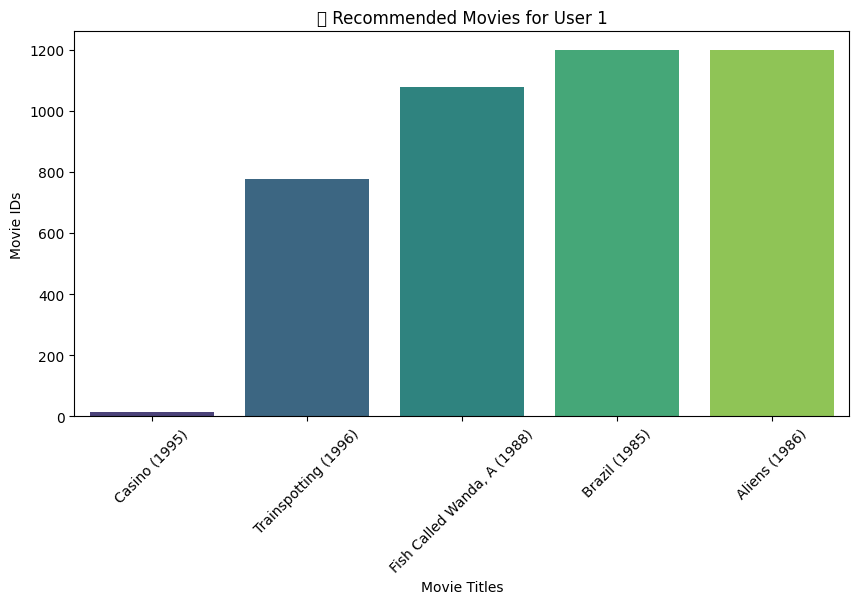

In [ ]:
# Ensure recommended_movies is a DataFrame
recommended_movie_ids = [16, 778, 1079, 1199, 1200]  # Based on your previous output
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

# Plotting recommended movies
plt.figure(figsize=(10, 5))
sns.barplot(x='title', y='movieId', data=recommended_movies, palette='viridis')
plt.title('🎯 Recommended Movies for User 1')
plt.xlabel('Movie Titles')
plt.ylabel('Movie IDs')
plt.xticks(rotation=45)
plt.show()


<ipython-input-10-ab31f539c252>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


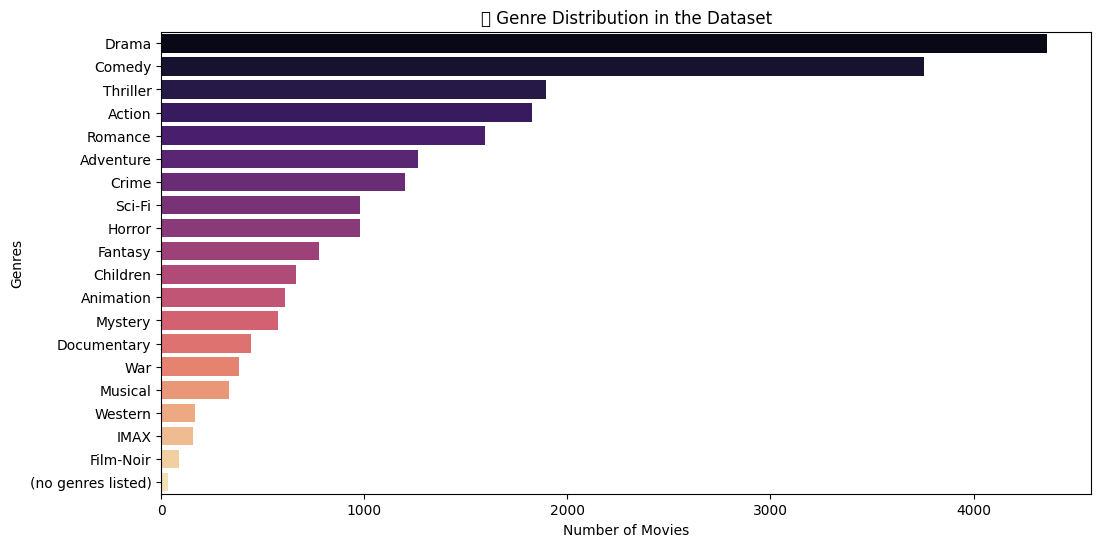

In [ ]:
# Splitting genres
genres_expanded = movies['genres'].str.get_dummies(sep='|')

# Summing genre counts
genre_counts = genres_expanded.sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
plt.title('🎥 Genre Distribution in the Dataset')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.show()
